# Preparation

We performed **data wrangling** to simultaneously explore, understand, and clean the dataset.  
During the initial retrieval from the **IGDB API**, we applied a **first filter** to focus on relevant games:

- `first_release_date` between the selected start and end timestamps  
- `game_type` limited to main games, expansions, and **remakes/remasters** (excluding DLCs, bundles, and ports).  
  > This ensures that the remakes and remasters included are “true” versions, not simple platform ports.  
- `aggregated_rating or rating` not null  

> **Note:** IGDB is a fully public database, and its data can be freely used.

In [1]:
import pandas as pd
import numpy as np
import missingno
from collections import Counter

## Import data and create dataframe

In [2]:
# Our data from IGPD
df = pd.read_csv("data.csv")

In [3]:
# Let's look at the name of each column
df.columns

Index(['id', 'cover', 'platform_family', 'rating', 'aggregated_rating',
       'game_modes', 'CERO', 'collections', 'USK', 'dlcs', 'platforms',
       'generation_platform', 'game_engines', 'player_perspectives',
       'game_type', 'developer_country', 'publisher_company', 'rating_count',
       'ESRB', 'genres', 'GRAC', 'platform_type', 'remake',
       'publisher_country', 'aggregated_rating_count', 'developer_company',
       'CLASS_IND', 'name', 'remaster', 'PEGI', 'first_release_date', 'ACB',
       'early_access'],
      dtype='object')

In [4]:
# Let's put everything back in the correct order
columns_order = [
    'name', 'first_release_date', 'cover','aggregated_rating', 'aggregated_rating_count', 'rating', 'rating_count', # Identification
    'developer_company', 'developer_country','publisher_company', 'publisher_country', # developer / publisher
    'platforms', 'platform_family', 'platform_type', 'generation_platform', # platform
    'GRAC', 'ESRB', 'CERO', 'PEGI', 'USK', 'CLASS_IND', 'ACB', # Age classification
    'game_type', 'game_modes', 'player_perspectives', 'genres', 'game_engines',  # Game characteristic
    'collections', 'remake', 'remaster', 'early_access', 'dlcs', # Details around the game
]

df = df[columns_order]

In [5]:
# read the top
df.head()

,name,first_release_date,cover,aggregated_rating,aggregated_rating_count,rating,rating_count,developer_company,developer_country,publisher_company,...,game_type,game_modes,player_perspectives,genres,game_engines,collections,remake,remaster,early_access,dlcs
0,Retaliate,2024-07-15,//images.igdb.com/igdb/image/upload/t_thumb/co...,76.0,1.0,NaN,NaN,['Romans I XVI Gaming'],['United States'],['Romans I XVI Gaming'],...,Main Game,['Single player'],['Bird view / Isometric'],"['Shooter', 'Indie', 'Arcade']",['MonoGame'],[],0,0,0,0
1,MX vs. ATV: Supercross - Encore,2015-10-27,//images.igdb.com/igdb/image/upload/t_thumb/co...,20.0,2.0,50.0,2.0,['Rainbow Studios'],['United States'],['Nordic Games Publishing'],...,Main Game,"['Single player', 'Multiplayer']","['First person', 'Third person']","['Racing', 'Simulator', 'Sport']",[],['MX'],0,0,0,7
2,Super Hipster Lumberjack,2015-07-20,//images.igdb.com/igdb/image/upload/t_thumb/co...,NaN,NaN,80.0,0.0,[],[],[],...,Main Game,['Single player'],[],"['Platform', 'Indie']",[],[],0,0,0,0
3,Trianga's Project: Battle Splash 2.0,2023-09-26,//images.igdb.com/igdb/image/upload/t_thumb/co...,NaN,NaN,70.0,1.0,[],[],[],...,Main Game,"['Single player', 'Multiplayer', 'Co-operative']","['First person', 'Third person']","['Shooter', 'Sport', 'Indie']",[],[],0,0,0,1
4,Go-Go Town!,2024-06-18,//images.igdb.com/igdb/image/upload/t_thumb/co...,85.0,1.0,NaN,NaN,['Prideful Sloth'],['Unknown(36)'],"['Cult Games', 'Prideful Sloth']",...,Main Game,"['Single player', 'Multiplayer', 'Co-operative...",['Third person'],"['Simulator', 'Indie']",['Unity'],[],0,0,1,0


### Data Overview

Let's explore each column in our dataset to understand the type of data we have.

#### Identification
- **name** - Name of the game
- **first_release_date** - Date when the game was first released
- **cover** - Cover image of the game
- **aggregated_rating** - Average official test rating for the game
- **aggregated_rating_count** - Number of ratings received
- **rating** - unofficial test
- **rating_count** - Number of unofficial test received

#### Developer / Publisher
- **developer_company** - Company that developed the game
- **developer_country** - Country of the developer company
- **publisher_company** - Company that published the game
- **publisher_country** - Country of the publisher company

#### Platforms
- **platforms** - Specific platforms where the game is available (PC, PS5, Switch, etc.)
- **platform_family** - Group of similar platforms (e.g., PlayStation, Xbox, Nintendo)
- **platform_type** - Type of platform (console, etc.)
- **generation_platform** - Generation of the platform (e.g., 6, 7)

#### Age Ratings
- **Age Rating GRAC** - Age rating from GRAC (Korean)
- **Age Rating ESRB** - Age rating from ESRB (North America)
- **Age Rating CERO** - Age rating from CERO (Japan)
- **Age Rating PEGI** - Age rating from PEGI (Europe)
- **Age Rating USK** - Age rating from USK (Germany)
- **Age Rating CLASS_IND** - Age rating from CLASS IND (Brazil)
- **Age Rating ACB** - Age rating from ACB (Australia)

#### Game Characteristics
- **game_type** - Type or category of the game (e.g., single-player, multiplayer)
- **game_modes** - Available modes (e.g., co-op, online, local multiplayer)
- **player_perspectives** - Perspective from which the game is played (e.g., first-person, third-person)
- **genres** - Genres of the game (e.g., action, RPG, indie)
- **game_engines** - Game engine used to develop the game

#### Details around the game
- **collections** - The collection
- **remake** - If the game has a remake
- **remaster** - If the game has a remaster
- **early_access** - If the game was released in early access (currently !)
- **dlcs** - Number of dlcs

### Types

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29838 entries, 0 to 29837
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     29838 non-null  object 
 1   first_release_date       29838 non-null  object 
 2   cover                    28397 non-null  object 
 3   aggregated_rating        13362 non-null  float64
 4   aggregated_rating_count  13362 non-null  float64
 5   rating                   25861 non-null  float64
 6   rating_count             25861 non-null  float64
 7   developer_company        29838 non-null  object 
 8   developer_country        29838 non-null  object 
 9   publisher_company        29838 non-null  object 
 10  publisher_country        29838 non-null  object 
 11  platforms                29838 non-null  object 
 12  platform_family          29838 non-null  object 
 13  platform_type            29838 non-null  object 
 14  generation_platform   

In [7]:
df["name"] = df["name"].astype("string")
df["first_release_date"] = df["first_release_date"].astype("datetime64[ns]")
df["cover"] = df["cover"].astype("string")
df["rating"] = df["rating"].astype("float64")
df["rating_count"] = df["rating_count"].astype("Int64")
df["aggregated_rating"] = df["aggregated_rating"].astype("float64")
df["aggregated_rating_count"] = df["aggregated_rating_count"].astype("Int64")
df["developer_company"] = df["developer_company"].astype("object")
df["developer_country"] = df["developer_country"].astype("object")
df["publisher_company"] = df["publisher_company"].astype("object")
df["publisher_country"] = df["publisher_country"].astype("object")
df["platforms"] = df["platforms"].astype("object")
df["platform_family"] = df["platform_family"].astype("object")
df["platform_type"] = df["platform_type"].astype("category")
df["generation_platform"] = df["generation_platform"].astype("Int64")
df["ACB"] = df["ACB"].astype("category")
df["CERO"] = df["CERO"].astype("category")
df["GRAC"] = df["GRAC"].astype("category")
df["ESRB"] = df["ESRB"].astype("category")
df["PEGI"] = df["PEGI"].astype("category")
df["USK"] = df["USK"].astype("category")
df["CLASS_IND"] = df["CLASS_IND"].astype("category")
df["game_type"] = df["game_type"].astype("category")
df["game_modes"] = df["game_modes"].astype("object")
df["player_perspectives"] = df["player_perspectives"].astype("object")
df["genres"] = df["genres"].astype("object")
df["game_engines"] = df["game_engines"].astype("object")
df["collections"] = df["collections"].astype("object")
df["remake"] = df["remake"].astype("bool")
df["remaster"] = df["remaster"].astype("bool")
df["early_access"] = df["early_access"].astype("bool")
df["dlcs"] = df["dlcs"].astype("int64")

# transform in true python list
df["developer_company"] = df["developer_company"].apply(eval)
df["developer_country"] = df["developer_country"].apply(eval)
df["publisher_company"] = df["publisher_company"].apply(eval)
df["publisher_country"] = df["publisher_country"].apply(eval)
df["platforms"] = df["platforms"].apply(eval)
df["platform_family"] = df["platform_family"].apply(eval)
df["game_modes"] = df["game_modes"].apply(eval)
df["player_perspectives"] = df["player_perspectives"].apply(eval)
df["genres"] = df["genres"].apply(eval)
df["game_engines"] = df["game_engines"].apply(eval)
df["collections"] = df["collections"].apply(eval)

## Missing value

Now, we will handle the missing values, which could hinder our analysis

<Axes: >

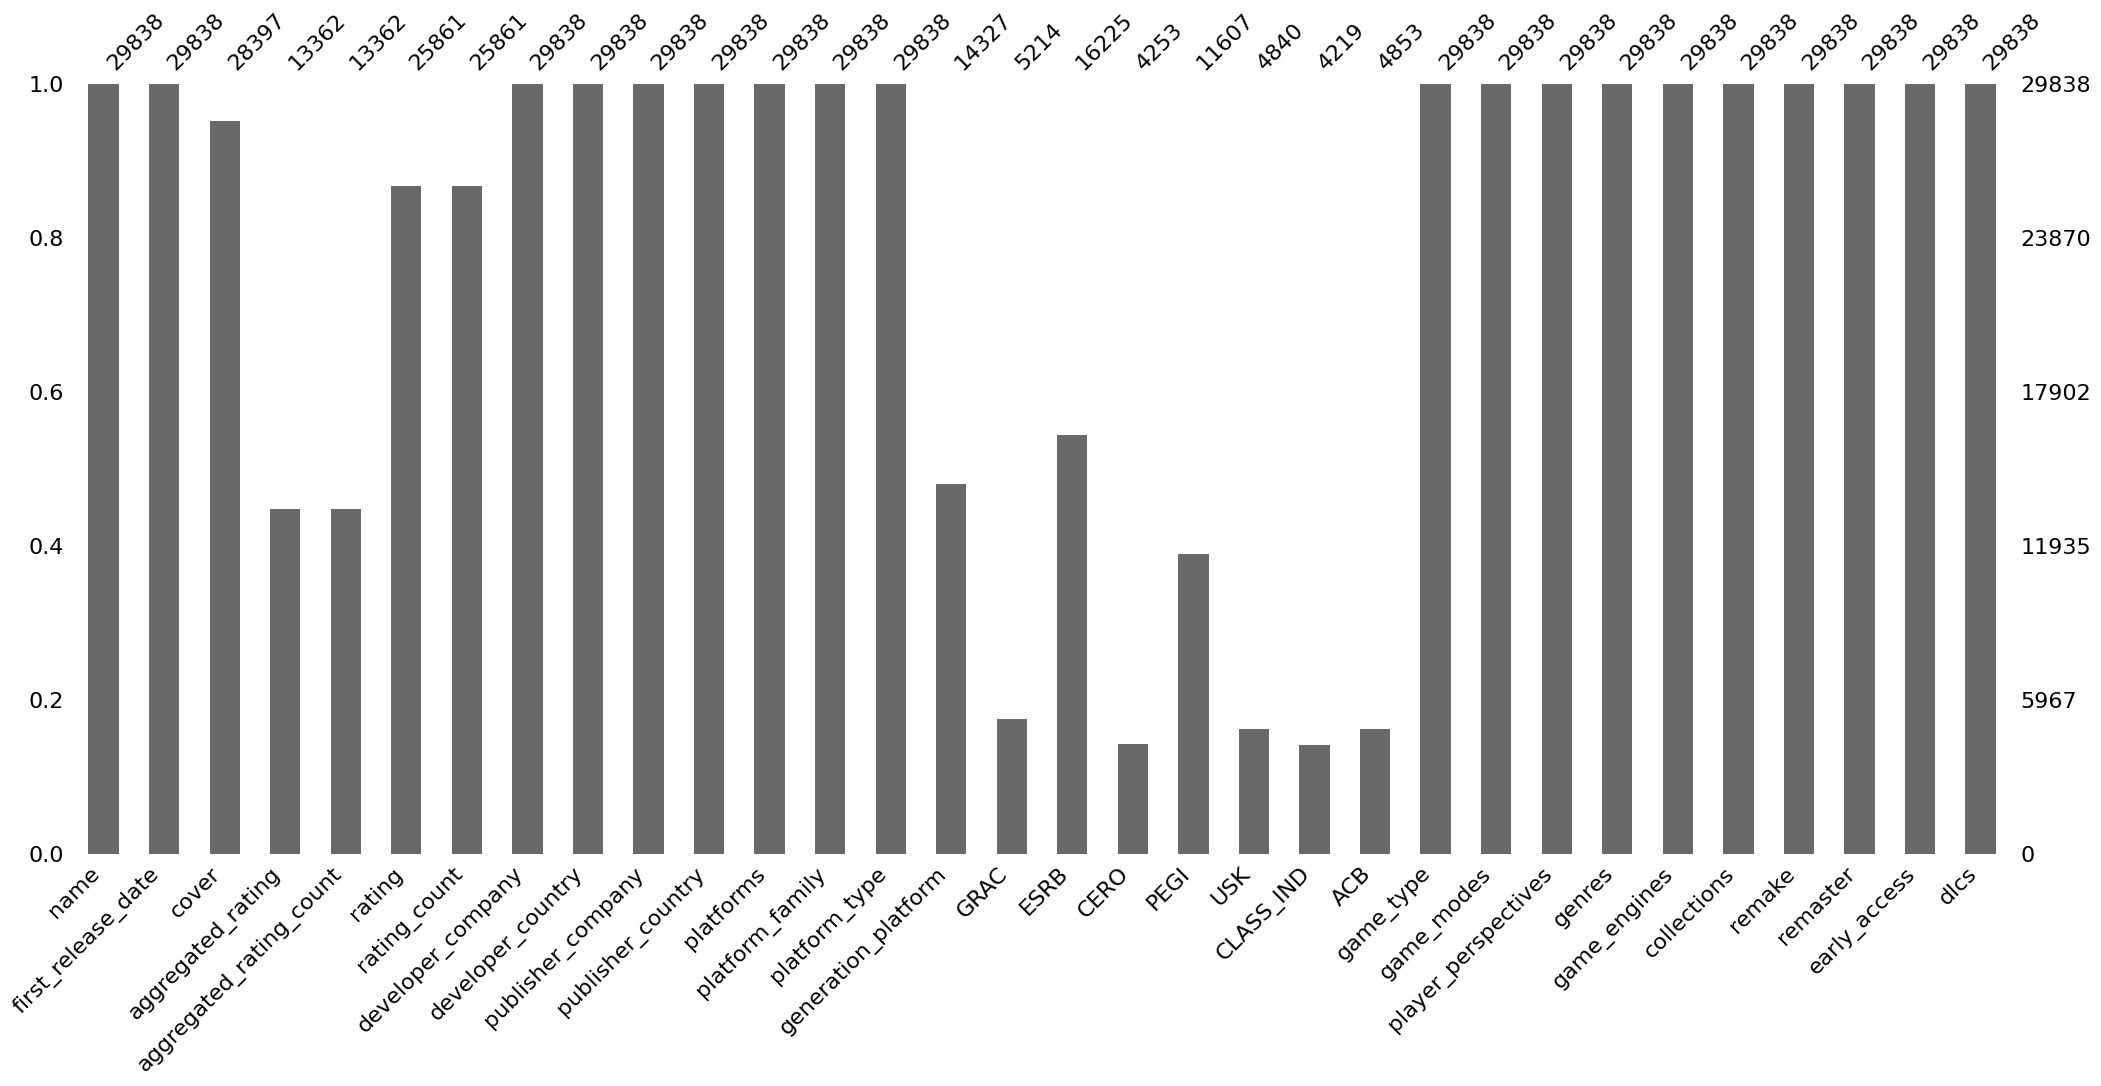

In [8]:
missingno.bar(df)

### Cover

We can assign a default cover for all games that don't have one

In [9]:
df["cover"] = df["cover"].fillna("https://i.imgur.com/VsWBrKg.jpeg")

### Rating count

We want to apply a confidence level to the ratings. 
- If no journalist rating exists, we use the player rating but with no confidence. 
- If a journalist rating exists, we take the average with the player rating and set the confidence to "yes." 
- If there are fewer than 2 journalist votes and fewer than 50 player votes, then the confidence is also set to null. 
- Finally, VR games also have a null confidence level

In [10]:
df["total_rating"] = ((df["aggregated_rating"].fillna(0) + df["rating"].fillna(0)) / ((df["aggregated_rating"].notnull()).astype(int) + (df["rating"].notnull()).astype(int)))

df["has_reliable_votes"] = df["aggregated_rating"].notnull() & df["rating"].notnull()
too_few_votes = (df["aggregated_rating_count"].fillna(0) < 2) & (df["rating_count"].fillna(0) < 50)
df.loc[too_few_votes, "has_reliable_votes"] = False

vr_mask = df["player_perspectives"].apply(lambda x: "Virtual Reality" in x if isinstance(x, list) else False)
df.loc[vr_mask, "has_reliable_votes"] = False

df["total_rating"] = df["total_rating"].astype("float64")
df["has_reliable_votes"] = df["has_reliable_votes"].astype("bool")

In [11]:
df = df.drop(columns=["rating", "rating_count", "aggregated_rating", "aggregated_rating_count"])

### Generation Platform

The generation of game is directly linked to the platform. True, there are no missing values, but do we have any []? That’s the first thing to check

In [12]:
print((df["platforms"].apply(len) == 0).sum())

0


We know that the generation takes the maximum of the platforms, so everything indicated in the generation column is necessarily linked to an existing platform. Since there are no empty lists, the remaining games are either on PC or on mobile. In both cases, we will assign them generation 0

In [13]:
df["generation_platform"] = df["generation_platform"].apply(lambda x: 0 if pd.isna(x) else x)

### Age Rating

In [14]:
# We identify rows
df[["ACB", "CERO", "GRAC", "ESRB", "PEGI", "USK", "CLASS_IND"]].dropna(thresh=1)

,ACB,CERO,GRAC,ESRB,PEGI,USK,CLASS_IND
0,G,NaN,ALL,E,3.0,0.0,L
1,G,NaN,NaN,E,3.0,NaN,NaN
8,PG,A,12+,T,NaN,12.0,NaN
9,NaN,NaN,NaN,T,3.0,NaN,NaN
10,MA 15+,NaN,15+,M,16.0,12.0,14
...,...,...,...,...,...,...,...
29829,NaN,NaN,NaN,M,16.0,12.0,18
29831,NaN,C,12+,T,12.0,NaN,14
29832,NaN,NaN,NaN,NaN,18.0,NaN,NaN
29834,NaN,NaN,NaN,M,16.0,NaN,14


In [15]:
df["CLASS_IND"].unique()

['L', NaN, '14', '12', '10', '16', '18']
Categories (6, object): ['10', '12', '14', '16', '18', 'L']

In [16]:
cols = ["ACB", "CERO", "GRAC", "ESRB", "PEGI", "USK", "CLASS_IND"]

# Mapping of rating codes to standardized age groups
def map_to_tranche(value):
    # Everyone
    if value in ["G", "A", "ALL", "E", 3.0, 0.0, "L"]:
        return "Everyone"
    # Child
    elif value in ["PG", "B", "ALL", "E10+", 7.0, 6.0, "10"]:
        return "Child"
    # Teen
    elif value in ["M", "C", "12+", "T", "12", 12.0]:
        return "Teen"
    # Young
    elif value in ["MA 15+", "D", "15+", "M", 16.0, "14"]:
        return "Young"
    # 18+
    elif value in ["R 18+", "RC", "Z", "19+", "AO", "RP", "EC", 18.0, "18"]:
        return "18+"
    else:
        return None

# Combine multiple rating system columns into one unified age group
def combined_tranche(row):
    values = row.dropna().values
    
    # If all columns are missing
    if len(values) == 0:
        return np.nan
    
    # Map each rating to its corresponding tranche
    tranches = [map_to_tranche(v) for v in values if map_to_tranche(v) is not None]
    
    # If no valid mapping found
    if len(tranches) == 0:
        return np.nan
    
    # Return the most common tranche
    most_common = Counter(tranches).most_common(1)[0][0]
    return most_common

# Apply mapping to the dataframe
df["age_rattings"] = df[cols].apply(combined_tranche, axis=1)

In [17]:
df = df.drop(cols, axis=1)

<Axes: >

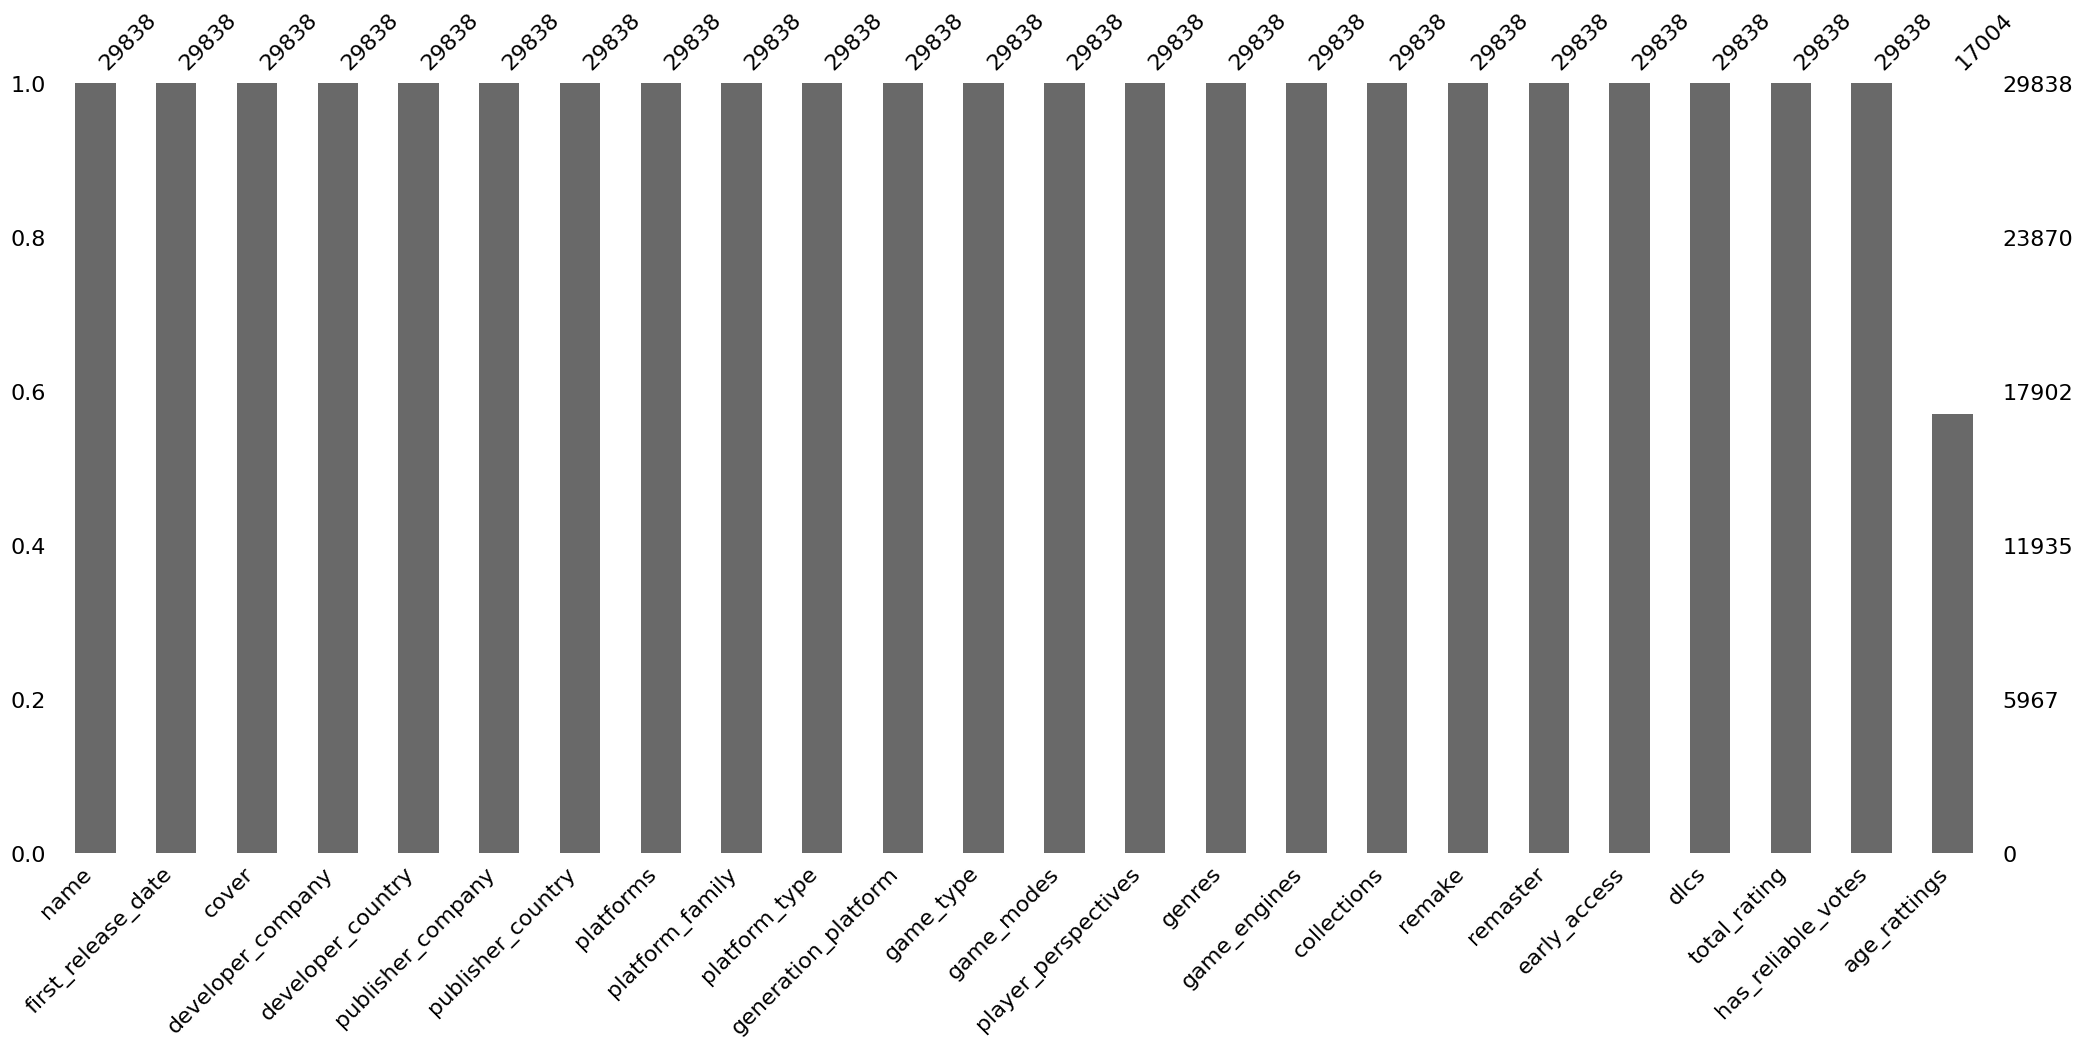

In [18]:
missingno.bar(df)

In [19]:
# Missing age ratings are set to "Everyone" since our analysis focuses on the evolution of video games
df["age_rattings"] = df["age_rattings"].fillna("Everyone")

### Besides the missing values, we also need to check for empty lists

#### Developer / publiser

In [20]:
# Number of developers with an empty list
print((df["developer_company"].apply(len) == 0).sum())
print("percentage: ",(df["developer_company"].apply(len) == 0).sum() / len(df) * 100)

7148
percentage:  23.956029224478854


In [21]:
# Number of publishers with an empty list
print((df["publisher_company"].apply(len) == 0).sum())
print("percentage: ",(df["publisher_company"].apply(len) == 0).sum() / len(df) * 100)

6422
percentage:  21.52289027414706


In [22]:
# Number of developer with an empty list BUT we know publishers
print(((df["developer_company"].apply(len) == 0) & (df["publisher_company"].apply(len) != 0)).sum())

1573


In [23]:
# Complete this case
df.loc[(df["developer_company"].apply(len) == 0) & (df["publisher_company"].apply(len) != 0), "developer_company"] = df["publisher_company"]
df.loc[(df["developer_country"].apply(len) == 0) & (df["publisher_country"].apply(len) != 0), "developer_country"] = df["publisher_country"]

In [24]:
# Number of developers with an empty list after first completion
print((df["developer_company"].apply(len) == 0).sum())
print("percentage: ",(df["developer_company"].apply(len) == 0).sum() / len(df) * 100)

5575
percentage:  18.684228165426635


In [25]:
# Number of publishers with an empty list BUT we know developpers
print(((df["developer_company"].apply(len) != 0) & (df["publisher_company"].apply(len) == 0)).sum())

847


In [26]:
# Complete this case
df.loc[(df["developer_company"].apply(len) != 0) & (df["publisher_company"].apply(len) == 0), "publisher_company"] = df["developer_company"]
df.loc[(df["developer_country"].apply(len) != 0) & (df["publisher_country"].apply(len) == 0), "publisher_country"] = df["developer_country"]

In [27]:
# Number of publishers with an empty list after first completion
print((df["publisher_company"].apply(len) == 0).sum())
print("percentage: ",(df["publisher_company"].apply(len) == 0).sum() / len(df) * 100)

5575
percentage:  18.684228165426635


In [28]:
(df[(df["publisher_company"].apply(len) != 0) & (df["publisher_country"].apply(lambda x: any(c is None for c in x)))])

,name,first_release_date,cover,developer_company,developer_country,publisher_company,publisher_country,platforms,platform_family,platform_type,...,genres,game_engines,collections,remake,remaster,early_access,dlcs,total_rating,has_reliable_votes,age_rattings
4,Go-Go Town!,2024-06-18,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Prideful Sloth],[Unknown(36)],"[Cult Games, Prideful Sloth]","[None, Unknown(36)]","[Xbox Series X|S, PlayStation 4, PC (Microsoft...","[Xbox, PlayStation, PlayStation, Xbox, Nintendo]","['Console', 'Console', 'Operating_system', 'Co...",...,"[Simulator, Indie]",[Unity],[],False,False,True,0,85.000000,False,Everyone
6,Super Space Pug,2016-06-04,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Digital Dawn Studios],[None],[Back To Basics Gaming],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Shooter, Indie]",[],[],False,False,False,0,50.000000,False,Everyone
8,ReCore,2016-09-13,//images.igdb.com/igdb/image/upload/t_thumb/co...,"[Armature Studio, Comcept]","[United States, Japan]",[Microsoft Studios],[None],"[PC (Microsoft Windows), Xbox One]",[Xbox],"['Operating_system', 'Console']",...,"[Platform, Adventure]",[],[],False,False,False,0,65.352642,True,Teen
9,Mad Bullets,2016-06-10,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Istom Games Kft.],[None],[Istom Games Kft.],[None],"[PC (Microsoft Windows), Nintendo Switch]",[Nintendo],"['Operating_system', 'Console']",...,"[Shooter, Indie, Arcade]",[],[],False,False,False,0,80.000000,False,Teen
10,Despotism 3k,2018-11-08,//images.igdb.com/igdb/image/upload/t_thumb/co...,"[Gameplay First Studios, Konfa Games]","[None, None]","[Gameplay First Studios, Konfa Games]","[None, None]","[PlayStation 4, Linux, Android, PC (Microsoft ...","[PlayStation, Linux, Linux, Xbox, Nintendo]","['Console', 'Operating_system', 'Operating_sys...",...,"[Simulator, Strategy, Indie]",[Unity],[],False,False,False,0,73.956784,False,Young
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29825,Knights and Merchants: The Peasants Rebellion,2001-11-26,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Joymania Entertainment],[Germany],"[Linux Game Publishing, Interactive Magic, Top...","[None, None, Germany]","[Linux, PC (Microsoft Windows), Mac]",[Linux],"['Operating_system', 'Operating_system', 'Oper...",...,"[Real Time Strategy (RTS), Simulator, Strategy]",[],[Knights and Merchants],False,False,False,0,85.186658,False,Teen
29827,Celtic Kings: Rage of War,2002-08-21,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Haemimont Games],[Bulgaria],"[Strategy First, Infogrames Entertainment, FX ...","[Canada, None, Spain, France]",[PC (Microsoft Windows)],[],['Operating_system'],...,"[Real Time Strategy (RTS), Role-playing (RPG),...",[],[],False,False,False,0,70.000000,False,Everyone
29832,Inner Chains,2017-05-18,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Telepaths' Tree],[None],[IMGN.PRO],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Shooter, Adventure]",[],[],False,False,False,0,49.442035,False,18+
29834,Mark of the Ninja,2012-09-07,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Klei Entertainment],[Canada],[Microsoft Studios],[None],"[Linux, PC (Microsoft Windows), Mac, Xbox 360]","[Linux, Xbox]","['Operating_system', 'Operating_system', 'Oper...",...,"[Platform, Adventure, Indie]",[Proprietary Engine],[],False,True,False,1,87.892486,True,Young


In [29]:
def replace_country(countries_list, error, new_country):
    countries_list = [new_country if c == error else c for c in countries_list]
    return countries_list

df["developer_country"] = df.apply(lambda row: replace_country(row["developer_country"], "Unknown(36)", "Australia"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country(row["publisher_country"], "Unknown(36)", "Australia"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country(row["developer_country"], "Unknown(40)", "Austria"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country(row["publisher_country"], "Unknown(40)", "Austria"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country(row["developer_country"], "Unknown(76)", "Brazil"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country(row["publisher_country"], "Unknown(76)", "Brazil"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country(row["developer_country"], "Unknown(32)", "Argentina"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country(row["publisher_country"], "Unknown(32)", "Argentina"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country(row["developer_country"], "Unknown(56)", "Belgium"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country(row["publisher_country"], "Unknown(56)", "Belgium"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country(row["developer_country"], "Unknown(50)", "Bangladesh"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country(row["publisher_country"], "Unknown(50)", "Bangladesh"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country(row["developer_country"], "Unknown(51)", "Armenia"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country(row["publisher_country"], "Unknown(51)", "Armenia"),axis=1)

In [30]:
def clean_countries(countries_list):
    non_none = [c for c in countries_list if c is not None]
    return non_none if non_none else countries_list

df["publisher_country"] = df["publisher_country"].apply(clean_countries)
df["developer_country"] = df["developer_country"].apply(clean_countries)

In [31]:
(df[(df["publisher_company"].apply(len) != 0) & (df["publisher_country"].apply(lambda x: any(c is None for c in x)))])

,name,first_release_date,cover,developer_company,developer_country,publisher_company,publisher_country,platforms,platform_family,platform_type,...,genres,game_engines,collections,remake,remaster,early_access,dlcs,total_rating,has_reliable_votes,age_rattings
6,Super Space Pug,2016-06-04,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Digital Dawn Studios],[None],[Back To Basics Gaming],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Shooter, Indie]",[],[],False,False,False,0,50.000000,False,Everyone
8,ReCore,2016-09-13,//images.igdb.com/igdb/image/upload/t_thumb/co...,"[Armature Studio, Comcept]","[United States, Japan]",[Microsoft Studios],[None],"[PC (Microsoft Windows), Xbox One]",[Xbox],"['Operating_system', 'Console']",...,"[Platform, Adventure]",[],[],False,False,False,0,65.352642,True,Teen
9,Mad Bullets,2016-06-10,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Istom Games Kft.],[None],[Istom Games Kft.],[None],"[PC (Microsoft Windows), Nintendo Switch]",[Nintendo],"['Operating_system', 'Console']",...,"[Shooter, Indie, Arcade]",[],[],False,False,False,0,80.000000,False,Teen
10,Despotism 3k,2018-11-08,//images.igdb.com/igdb/image/upload/t_thumb/co...,"[Gameplay First Studios, Konfa Games]","[None, None]","[Gameplay First Studios, Konfa Games]","[None, None]","[PlayStation 4, Linux, Android, PC (Microsoft ...","[PlayStation, Linux, Linux, Xbox, Nintendo]","['Console', 'Operating_system', 'Operating_sys...",...,"[Simulator, Strategy, Indie]",[Unity],[],False,False,False,0,73.956784,False,Young
12,Now You See,2019-09-30,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Screaming Void],[None],[Screaming Void],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Point-and-click, Adventure, Indie]",[],[],False,False,False,0,70.000000,False,Everyone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29815,Reservoir Dogs: Bloody Days,2017-05-18,//images.igdb.com/igdb/image/upload/t_thumb/s1...,[Big Games],[None],[Big Star Games],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Fighting, Shooter, Strategy, Indie]",[],[],False,False,False,0,45.500000,False,Teen
29823,Where Is My Heart?,2011-11-08,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Die Gute Fabrik],[Denmark],[Schulenburg Software],[None],"[PlayStation 3, PC (Microsoft Windows), Mac, P...","[PlayStation, PlayStation, PlayStation]","['Console', 'Operating_system', 'Operating_sys...",...,"[Platform, Puzzle, Adventure, Indie]",[],[],False,False,False,0,70.500000,True,Everyone
29832,Inner Chains,2017-05-18,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Telepaths' Tree],[None],[IMGN.PRO],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Shooter, Adventure]",[],[],False,False,False,0,49.442035,False,18+
29834,Mark of the Ninja,2012-09-07,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Klei Entertainment],[Canada],[Microsoft Studios],[None],"[Linux, PC (Microsoft Windows), Mac, Xbox 360]","[Linux, Xbox]","['Operating_system', 'Operating_system', 'Oper...",...,"[Platform, Adventure, Indie]",[Proprietary Engine],[],False,True,False,1,87.892486,True,Young


In [32]:
(df[(df["publisher_company"].apply(len) != 0) & (df["publisher_country"].apply(lambda x: any(c is None for c in x)))])

,name,first_release_date,cover,developer_company,developer_country,publisher_company,publisher_country,platforms,platform_family,platform_type,...,genres,game_engines,collections,remake,remaster,early_access,dlcs,total_rating,has_reliable_votes,age_rattings
6,Super Space Pug,2016-06-04,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Digital Dawn Studios],[None],[Back To Basics Gaming],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Shooter, Indie]",[],[],False,False,False,0,50.000000,False,Everyone
8,ReCore,2016-09-13,//images.igdb.com/igdb/image/upload/t_thumb/co...,"[Armature Studio, Comcept]","[United States, Japan]",[Microsoft Studios],[None],"[PC (Microsoft Windows), Xbox One]",[Xbox],"['Operating_system', 'Console']",...,"[Platform, Adventure]",[],[],False,False,False,0,65.352642,True,Teen
9,Mad Bullets,2016-06-10,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Istom Games Kft.],[None],[Istom Games Kft.],[None],"[PC (Microsoft Windows), Nintendo Switch]",[Nintendo],"['Operating_system', 'Console']",...,"[Shooter, Indie, Arcade]",[],[],False,False,False,0,80.000000,False,Teen
10,Despotism 3k,2018-11-08,//images.igdb.com/igdb/image/upload/t_thumb/co...,"[Gameplay First Studios, Konfa Games]","[None, None]","[Gameplay First Studios, Konfa Games]","[None, None]","[PlayStation 4, Linux, Android, PC (Microsoft ...","[PlayStation, Linux, Linux, Xbox, Nintendo]","['Console', 'Operating_system', 'Operating_sys...",...,"[Simulator, Strategy, Indie]",[Unity],[],False,False,False,0,73.956784,False,Young
12,Now You See,2019-09-30,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Screaming Void],[None],[Screaming Void],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Point-and-click, Adventure, Indie]",[],[],False,False,False,0,70.000000,False,Everyone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29815,Reservoir Dogs: Bloody Days,2017-05-18,//images.igdb.com/igdb/image/upload/t_thumb/s1...,[Big Games],[None],[Big Star Games],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Fighting, Shooter, Strategy, Indie]",[],[],False,False,False,0,45.500000,False,Teen
29823,Where Is My Heart?,2011-11-08,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Die Gute Fabrik],[Denmark],[Schulenburg Software],[None],"[PlayStation 3, PC (Microsoft Windows), Mac, P...","[PlayStation, PlayStation, PlayStation]","['Console', 'Operating_system', 'Operating_sys...",...,"[Platform, Puzzle, Adventure, Indie]",[],[],False,False,False,0,70.500000,True,Everyone
29832,Inner Chains,2017-05-18,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Telepaths' Tree],[None],[IMGN.PRO],[None],[PC (Microsoft Windows)],[],['Operating_system'],...,"[Shooter, Adventure]",[],[],False,False,False,0,49.442035,False,18+
29834,Mark of the Ninja,2012-09-07,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Klei Entertainment],[Canada],[Microsoft Studios],[None],"[Linux, PC (Microsoft Windows), Mac, Xbox 360]","[Linux, Xbox]","['Operating_system', 'Operating_system', 'Oper...",...,"[Platform, Adventure, Indie]",[Proprietary Engine],[],False,True,False,1,87.892486,True,Young


In [33]:
(df[(df["publisher_company"].apply(len) != 0) & (df["publisher_country"].apply(lambda x: any(c is None for c in x))) & (df["has_reliable_votes"] == True)])

,name,first_release_date,cover,developer_company,developer_country,publisher_company,publisher_country,platforms,platform_family,platform_type,...,genres,game_engines,collections,remake,remaster,early_access,dlcs,total_rating,has_reliable_votes,age_rattings
8,ReCore,2016-09-13,//images.igdb.com/igdb/image/upload/t_thumb/co...,"[Armature Studio, Comcept]","[United States, Japan]",[Microsoft Studios],[None],"[PC (Microsoft Windows), Xbox One]",[Xbox],"['Operating_system', 'Console']",...,"[Platform, Adventure]",[],[],False,False,False,0,65.352642,True,Teen
35,The Spirit and the Mouse,2022-09-26,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Alblune Games],[None],[Armor Games Studios],[None],"[PlayStation 4, PC (Microsoft Windows), PlaySt...","[PlayStation, PlayStation, Nintendo]","['Console', 'Operating_system', 'Console', 'Co...",...,"[Platform, Puzzle, Adventure, Indie]",[Unity],[],False,False,False,0,84.420556,True,Everyone
117,Epic Dumpster Bear,2016-04-07,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Log Games],[None],[Log Games],[None],"[PlayStation 4, PC (Microsoft Windows), Wii U]","[PlayStation, Nintendo]","['Console', 'Operating_system', 'Console']",...,"[Platform, Adventure, Indie]",[Unity],[],False,False,False,0,72.500000,True,Child
120,Jon Shafer's At the Gates,2019-01-23,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Conifer Games],[None],[Conifer Games],[None],"[Linux, PC (Microsoft Windows), iOS, Mac]",[Linux],"['Operating_system', 'Operating_system', 'Oper...",...,"[Strategy, Turn-based strategy (TBS), Indie]",[],[],False,False,False,0,60.583333,True,Everyone
214,Paint it Back,2013-10-01,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Casual Labs],[None],[Casual Labs],[None],"[Linux, PC (Microsoft Windows), iOS, Mac]",[Linux],"['Operating_system', 'Operating_system', 'Oper...",...,"[Puzzle, Indie]",[],[],False,False,False,0,85.000000,True,Everyone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29753,Cannibal Cuisine,2020-05-20,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Rocket Vulture],[None],[Rocket Vulture],[None],"[Xbox Series X|S, PlayStation 4, PC (Microsoft...","[Xbox, PlayStation, PlayStation, Xbox, Nintendo]","['Console', 'Console', 'Operating_system', 'Co...",...,"[Simulator, Adventure, Indie, Arcade]",[],[],False,False,False,0,68.000000,True,Teen
29779,Subterrain,2016-01-21,//images.igdb.com/igdb/image/upload/t_thumb/co...,[PixelLore],[None],[PixelLore],[None],"[PlayStation 4, PC (Microsoft Windows), Xbox One]","[PlayStation, Xbox]","['Console', 'Operating_system', 'Console']",...,"[Shooter, Role-playing (RPG), Simulator, Strat...",[Unity],[],False,False,False,0,68.447994,True,Teen
29783,101 Ways to Die,2016-03-17,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Four Door Lemon],[United Kingdom],[Vision Games Publishing],[None],"[PlayStation 4, PC (Microsoft Windows), Xbox One]","[PlayStation, Xbox]","['Console', 'Operating_system', 'Console']",...,"[Platform, Puzzle, Strategy, Indie]",[],[],False,False,False,0,65.000000,True,Teen
29823,Where Is My Heart?,2011-11-08,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Die Gute Fabrik],[Denmark],[Schulenburg Software],[None],"[PlayStation 3, PC (Microsoft Windows), Mac, P...","[PlayStation, PlayStation, PlayStation]","['Console', 'Operating_system', 'Operating_sys...",...,"[Platform, Puzzle, Adventure, Indie]",[],[],False,False,False,0,70.500000,True,Everyone


In [34]:
distinct_publishers = set(c for sublist in df[(df["publisher_company"].apply(len) != 0) &(df["publisher_country"].apply(lambda x: any(c is None for c in x))) &(df["has_reliable_votes"] == True)]["publisher_company"]for c in sublist)
distinct_publishers

{'24 Caret Games',
 '2K',
 '3909',
 '3DO',
 '4PM GAME',
 '7Sixty',
 '7levels',
 '8th Floor Games',
 'AMA Studios',
 'Act 3 Games',
 'Activision Publishing',
 'Activision Publishing Minneapolis Inc.',
 'Adminde Ltd',
 'Adriaan de Jongh',
 'Affable Games',
 'Akupara Games',
 'Aleksandar Kuzmanovic Games',
 'Alex Rose Games',
 'Alice & Smith',
 'All Yes Good',
 'Alliance Digital Media',
 'Ankama Games',
 'Anshar Publishing',
 'Anton Riot',
 'Archangel Studios',
 'Archiact',
 'Armor Games Studios',
 'Artvostok',
 'Assemble Entertainment',
 'Aterdux Entertainment',
 'Atooi',
 'Bacon Wrapped Games',
 'Bad Guitar Studio',
 'Bad Habit Productions',
 'Beau Blyth',
 'Beep Games',
 'Benjamin Rivers',
 'Big Sugar',
 'Bit Blot',
 'Bitbox S.L.',
 'Black Bean Games',
 'Black inc',
 'Blackpowder Games',
 'Brandon Brizzi',
 'Bromio',
 'Bulbware',
 'COWCAT',
 'Calvino Noir Limited',
 'Cantaloupe Kids',
 'Carbon Fire Studio',
 'Cartoon Network',
 'Cartoon Network Games',
 'Casual Labs',
 'Catch & Release

In [35]:
def replace_country_if_publisher_present(companies_list, countries_list, change_companies, new_country):
    if change_companies in companies_list:
        countries_list = [new_country if c is None else c for c in countries_list]
    return countries_list

df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Microsoft Studios", "United States"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Microsoft Studios", "United States"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Alblune Games", "Canada"),axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alblune Games", "Canada"),axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "24 Caret Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "24 Caret Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "2K", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "2K", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "3909", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "3909", "Unites States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "3DO", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "3DO", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "4PM GAME", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "4PM GAME", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "7Sixty", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "7Sixty", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "7levels", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "7levels", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "8th Floor Games", "Russian Federation"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "8th Floor Games", "Russian Federation"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "AMA Studios", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "AMA Studios", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Act 3 Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Act 3 Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Activision Publishing", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Activision Publishing", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Activision Publishing Minneapolis Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Activision Publishing Minneapolis Inc.", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Adminde Ltd", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Adminde Ltd", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Adriaan de Jongh", "Netherlands"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Adriaan de Jongh", "Netherlands"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Affable Games", "Australia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Affable Games", "Australia"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Akupara Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Akupara Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Aleksandar Kuzmanovic Games", "Serbia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Aleksandar Kuzmanovic Games", "Serbia"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Alex Rose Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alex Rose Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Alice & Smith", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alice & Smith", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "All Yes Good", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "All Yes Good", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Alliance Digital Media", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alliance Digital Media", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ankama Games", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ankama Games", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Anshar Publishing", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Anshar Publishing", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Anton Riot", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Anton Riot", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Archangel Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Archangel Studios", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Archiact", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Archiact", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Armor Games Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Armor Games Studios", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Artvostok", "Russian Federation"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Artvostok", "Russian Federation"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Assemble Entertainment", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Assemble Entertainment", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Aterdux Entertainment", "Belarus"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Aterdux Entertainment", "Belarus"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Atooi", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Atooi", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Bacon Wrapped Games", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bacon Wrapped Games", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Bad Guitar Studio", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bad Guitar Studio", "China"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Bad Habit Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bad Habit Productions", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Beau Blyth", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Beau Blyth", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Beep Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Beep Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Benjamin Rivers", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Benjamin Rivers", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Big Sugar", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Big Sugar", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Bit Blot", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bit Blot", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Bitbox S.L.", "Spain"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bitbox S.L.", "Spain"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Black Bean Games", "Italy"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Black Bean Games", "Italy"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Black inc", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Black inc", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Blackpowder Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Blackpowder Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Brandon Brizzi", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Brandon Brizzi", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Bromio", "Mexico"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bromio", "Mexico"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Bulbware", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bulbware", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "COWCAT", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "COWCAT", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "QCF Design", "South Africa"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "QCF Design", "South Africa"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Qooc Software", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Qooc Software", "China"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Quantum Phoenix", "Ukraine"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Quantum Phoenix", "Ukraine"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "QubicGames S.A.", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "QubicGames S.A.", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "RLR PUA", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "RLR PUA", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ragequit Corporation", "Greece"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ragequit Corporation", "Greece"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ratloop Asia", "Singapore"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ratloop Asia", "Singapore"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Red 5 Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Red 5 Studios", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "RedDeerGames", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "RedDeerGames", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "RedOctane", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "RedOctane", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Reef Entertainment", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Reef Entertainment", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Reverb Communications", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Reverb Communications", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Reverb Triple XP", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Reverb Triple XP", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "RichMakeGame", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "RichMakeGame", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Riot Forge", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Riot Forge", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ripstone", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ripstone", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Rocket Vulture", "Belgium"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rocket Vulture", "Belgium"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Rodaja", "Spain"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rodaja", "Spain"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Roman Uhlig", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Roman Uhlig", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "SCE Worldwide Studios Europe", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SCE Worldwide Studios Europe", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "SCi Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SCi Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Schulenburg Software", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Schulenburg Software", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Scientifically Proven", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Scientifically Proven", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sector D2", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sector D2", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Severed Press", "Australia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Severed Press", "Australia"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Calvino Noir Limited", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Calvino Noir Limited", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Cantaloupe Kids", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cantaloupe Kids", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Carbon Fire Studio", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Carbon Fire Studio", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Cartoon Network", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cartoon Network", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Cartoon Network Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cartoon Network Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Casual Labs", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Casual Labs", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Catch & Release, LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Catch & Release, LLC", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "ChiliDog Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ChiliDog Interactive", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Chilled Mouse", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Chilled Mouse", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Chromatic Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Chromatic Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Coatsink", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Coatsink", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "ColePowered Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ColePowered Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "ComonGames", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ComonGames", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Conifer Games", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Conifer Games", "Sweden"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Critical Forge", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Critical Forge", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Cult Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cult Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Curious Panda Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Curious Panda Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Cyber Rhino Studios", "Brazil"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cyber Rhino Studios", "Brazil"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "D3 Go!", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "D3 Go!", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "D3 Publisher", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "D3 Publisher", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "DEVGRU-P", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "DEVGRU-P", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "DIGIDICED", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "DIGIDICED", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Daedalic Studio West", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Daedalic Studio West", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dan & Gary Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dan & Gary Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dark Point Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dark Point Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Darril Arts", "Italy"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Darril Arts", "Italy"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Deck13 Spotlight", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Deck13 Spotlight", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Desert Owl Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Desert Owl Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Digital Cybercherries", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Digital Cybercherries", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Digital Dragons", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Digital Dragons", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Digital Smash", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Digital Smash", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Digital Tribe", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Digital Tribe", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Disparity Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Disparity Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Distractionware", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Distractionware", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Doragon Entertainment", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Doragon Entertainment", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dragonstone Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dragonstone Software", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "DreadXP", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "DreadXP", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dreadbit", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dreadbit", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dreadlocks Mobile", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dreadlocks Mobile", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dream Reactor", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dream Reactor", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dusenberry Martin Racing", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dusenberry Martin Racing", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Dylan Fitterer", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dylan Fitterer", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "EA", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EA", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "EA Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EA Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "EA Partners", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EA Partners", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "EA Sports BIG", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EA Sports BIG", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Edge Case Games Ltd.", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Edge Case Games Ltd.", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Edmund McMillen", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Edmund McMillen", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Elefantopia", "United Stated"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Elefantopia", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Eleventh Hour Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Eleventh Hour Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ellada Games", "Greece"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ellada Games", "Greece"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "En Masse Entertainment", "South Korea"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "En Masse Entertainment", "South Korea"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Engient, Inc", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Engient, Inc", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "EnjoyUp Games", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EnjoyUp Games", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Epic Games Publishing", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Epic Games Publishing", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Erik Svedäng AB", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Erik Svedäng AB", "Sweden"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "EuroVideo Medien", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EuroVideo Medien", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Evolved Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Evolved Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Eyebrow Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Eyebrow Interactive", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "FlukeDude", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "FlukeDude", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Flying Carpets Games", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Flying Carpets Games", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "FoamPunch", "United Statese"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "FoamPunch", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Foreign Gnomes", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Foreign Gnomes", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Four Lights", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Four Lights", "United Statese"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Fox Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fox Interactive", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "FoxNext Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "FoxNext Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Free Reign Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Free Reign Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Freeverse Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Freeverse Software", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Frontier Foundry", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Frontier Foundry", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Fulqrum Publishing", "Czechia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fulqrum Publishing", "Czechia"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Fun Punch", "Portugal"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fun Punch", "Portugal"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Funbox Media", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Funbox Media", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Futuremark", "Finland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Futuremark", "Finland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Futuremark Games Studio", "Finland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Futuremark Games Studio", "Finland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Gamecock Media Group", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Gamecock Media Group", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Gammick Entertainment", "Spain"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Gammick Entertainment", "Spain"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Garage227 Studios", "Brazil"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Garage227 Studios", "Brazil"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Gazillion Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Gazillion Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Genius Products", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Genius Products", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ginger Labs Inc", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ginger Labs Inc", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Gonzo Games", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Gonzo Games", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Good Catch Ltd", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Good Catch Ltd", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Green Lava Studios", "Costa Rica"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Green Lava Studios", "Costa Rica"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Green Man Gaming Publishing", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Green Man Gaming Publishing", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Green Man Loaded", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Green Man Loaded", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Grey Box", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Grey Box", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Grip Games", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Grip Games", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "HD Publishing", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HD Publishing", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Half Mermaid", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Half Mermaid", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Hammerfall Publishing", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hammerfall Publishing", "Sweden"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Handelabra Games Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Handelabra Games Inc.", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Headup Publishing", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Headup Publishing", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Headware Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Headware Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Hidden Gems Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hidden Gems Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "High Horse Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "High Horse Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "High Tale Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "High Tale Studios", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Humble Bundle", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Humble Bundle", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Humble Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Humble Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Humble Hearts", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Humble Hearts", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "HuniePot", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HuniePot", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Hypersect", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hypersect", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "I Fight Bears", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "I Fight Bears", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "IMGN.PRO", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "IMGN.PRO", "Germany"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ian MacLarty", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ian MacLarty", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ignition Entertainment", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ignition Entertainment", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "InFramez Technology", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "InFramez Technology", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "IndiePub", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "IndiePub", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Infinitap Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Infinitap Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Infinite Game Publishing", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Infinite Game Publishing", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Internet URL S.A.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Internet URL S.A.", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "InvertMouse", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "InvertMouse", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ivy Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ivy Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Jacob Janerka", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Jacob Janerka", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Jason Rohrer", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Jason Rohrer", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "JoyBits", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "JoyBits", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "K2 Network", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "K2 Network", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Kabam", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Kabam", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Kikiwik Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Kikiwik Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Kingdom Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Kingdom Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Klabater", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Klabater", "Poland"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Kyle Seeley", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Kyle Seeley", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "LaCosa Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "LaCosa Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Laura Shigihara", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Laura Shigihara", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Lockpickle", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lockpickle", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Log Games", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Log Games", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Lucas Arts", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lucas Arts", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Lucas Molina", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lucas Molina", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ludeme Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ludeme Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "MERJ Media", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "MERJ Media", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Mad Dog Games, LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mad Dog Games, LLC", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Magiko Gaming", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Magiko Gaming", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Majesco", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Majesco", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Micro Application S.A.", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Micro Application S.A.", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Midway Home Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Midway Home Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Mighty Rocket Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mighty Rocket Studios", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Milkbag Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Milkbag Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Minority", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Minority", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Moonshark, Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Moonshark, Inc.", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Motorsport Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Motorsport Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "MythicOwl", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "MythicOwl", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Naiad Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Naiad Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Nakana.io", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nakana.io", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Nanali Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nanali Studios", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "NetEase Games Montréal", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "NetEase Games Montréal", "Canada"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "New World Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "New World Interactive", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Newt Industries", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Newt Industries", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Nexon Co. Ltd.", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nexon Co. Ltd.", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Nexon Korea", "South Korea"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nexon Korea", "South Korea"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "No Pest Productions", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "No Pest Productions", "Sweden"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Nobilis", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nobilis", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "North Beach Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "North Beach Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Nuchallenger", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nuchallenger", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Ocean Media", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ocean Media", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "OneBigGame", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "OneBigGame", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Onion Games", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Onion Games", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Oointah Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Oointah Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Owl Cave", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Owl Cave", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "POISOFT", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "POISOFT", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "POLARIS-X", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "POLARIS-X", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Papaya Play", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Papaya Play", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Phosfiend Systems", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Phosfiend Systems", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Phosphor", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Phosphor", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "PixelLore", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "PixelLore", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Playlogic Entertainment", "Netherlands"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Playlogic Entertainment", "Netherlands"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "PomPom", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "PomPom", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "PomPom Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "PomPom Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Shining Rock Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Shining Rock Software", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Shiro Unlimited", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Shiro Unlimited", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sideline Amusements", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sideline Amusements", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sierra", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sierra", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Silver Dollar Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Silver Dollar Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Singularity 6", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Singularity 6", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sirvo", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sirvo", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Six Foot", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Six Foot", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Skookum Arts", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Skookum Arts", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Slick Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Slick Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sony Computer Entertainment Europe", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sony Computer Entertainment Europe", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sorath", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sorath", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sos", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sos", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sos Sosowski", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sos Sosowski", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Sparpweed Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sparpweed Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Spellbind Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Spellbind Studios", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Spooky Squid Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Spooky Squid Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Stairfall Institute", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Stairfall Institute", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Starry Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Starry Studio", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "State of Play Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "State of Play Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Steel Sky Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Steel Sky Productions", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Stolen Couch Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Stolen Couch Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Stygian Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Stygian Software", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Surefire.Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Surefire.Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tasharen Entertainment Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tasharen Entertainment Inc.", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tate Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tate Interactive", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Team17 Digital", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Team17 Digital", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tecmo", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tecmo", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tecmo Koei Games", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tecmo Koei Games", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Texel Raptor", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Texel Raptor", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "The Arcade Crew", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Arcade Crew", "France"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "The Dangerous Kitchen", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Dangerous Kitchen", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "The Good Mood Creators", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Good Mood Creators", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "The Imaginarium", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Imaginarium", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Thekla, Inc", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Thekla, Inc", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tictoc Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tictoc Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "TikGames", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "TikGames", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tomlab Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tomlab Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tommo Inc", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tommo Inc", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Touchstone Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Touchstone Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tour De Pizza", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tour De Pizza", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tozai Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tozai Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Triangle Service", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Triangle Service", "Japan"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Trickstar Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Trickstar Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Triternion", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Triternion", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Tru Blu Entertainment", "Australia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tru Blu Entertainment", "Australia"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "U&I Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "U&I Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "UTV Ignition Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "UTV Ignition Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "V7 Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "V7 Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "VLG Publishing", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "VLG Publishing", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "VU Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "VU Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Valcon Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Valcon Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Vanguard Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vanguard Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Vertex Pop", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vertex Pop", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Vigamus Leonardo", "Italy"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vigamus Leonardo", "Italy"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Vision Games Publishing", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vision Games Publishing", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Viz Media", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Viz Media", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "WG Labs", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "WG Labs", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Wahler Digital", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Wahler Digital", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Warner Bros. Interactive Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Warner Bros. Interactive Entertainment", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Whale Hammer Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Whale Hammer Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Whatboy Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Whatboy Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "WhisperGames", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "WhisperGames", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Whitethorn Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Whitethorn Games", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "William Chyr Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "William Chyr Studio", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Wizards of the Coast LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Wizards of the Coast LLC", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "X.D. Network Inc.", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "X.D. Network Inc.", "China"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Yanim Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Yanim Studio", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Yogscast Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Yogscast Games", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Yukitama Creative Industries", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Yukitama Creative Industries", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "aeiowu", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "aeiowu", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "bilibili", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "bilibili", "China"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "bitHuffel", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "bitHuffel", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "kiwiwalks", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "kiwiwalks", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "radiostatic", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "radiostatic", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Malfador Machinations", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Malfador Machinations", "United States"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Mark Healey", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mark Healey", "United Kingdom"), axis=1)
df["publisher_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["publisher_company"], row["publisher_country"], "Red Wagon Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Red Wagon Games", "United States"), axis=1)

In [36]:
(df[(df["publisher_company"].apply(len) != 0) & (df["publisher_country"].apply(lambda x: any(c is None for c in x))) & (df["has_reliable_votes"] == True)])

,name,first_release_date,cover,developer_company,developer_country,publisher_company,publisher_country,platforms,platform_family,platform_type,...,genres,game_engines,collections,remake,remaster,early_access,dlcs,total_rating,has_reliable_votes,age_rattings


In [37]:
distinct_developers = set(c for sublist in df[(df["developer_company"].apply(len) != 0) &(df["developer_country"].apply(lambda x: any(c is None for c in x))) &(df["has_reliable_votes"] == True)]["developer_company"]for c in sublist)
distinct_developers

{'1C:Ino-Co Plus',
 '2 Ton Studios',
 '24 Entertainment',
 '2tainment',
 '369 Interactive',
 '4HEAD Studios',
 '4mm Games',
 '7 Studios',
 '704Games Company',
 '8monkey Labs',
 'APLUS Co., Ltd.',
 'ASTRO PORT',
 'AWAR',
 'AWE Productions',
 'Acme Gamestudio',
 'Action Button Entertainment',
 'Adrenium Games',
 'Afterburner Studios',
 'Agatsuma',
 'Alan Zucconi',
 'Alasdair Beckett-King',
 'Alexander Bruce',
 'Alexey Bokulev',
 'Alexey Pajitnov',
 'All Possible Futures',
 'Altron',
 'Anarteam',
 'Aquaplus',
 'Area 34',
 'Area 35',
 'Argonaut Games',
 'Askiisoft',
 'AstralShift',
 'Atelier Mimina',
 'Atrax Game',
 'Autumn Moon Entertainment',
 'Awe Interactive',
 'Awesome Developments',
 'Bacon Bandit Games',
 'Baroque Decay',
 'Beethoven & Dinosaur',
 'Ben Esposito',
 'Big Boat Interactive',
 'Big Red Button',
 'BigPark',
 'Binokle Studio',
 'Binx Interactive',
 'Bionic Games',
 'Bit Loom Games',
 'Bits & Beasts',
 'Bits Studios',
 'Black Element Software',
 'Black Lantern Studios',
 'B

In [38]:
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "1C:Ino-Co Plus", "Russian Federation"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "2 Ton Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "24 Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "2tainment", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "369 Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "4HEAD Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "4mm Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "7 Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "704Games Company", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "8monkey Labs", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "APLUS Co., Ltd.", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ASTRO PORT", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "AWAR", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "AWE Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Acme Gamestudio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Action Button Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Adrenium Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Afterburner Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Agatsuma", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alan Zucconi", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alasdair Beckett-King", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alexander Bruce", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alexey Bokulev", "Russian Federation"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Alexey Pajitnov", "Russian Federation"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "All Possible Futures", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Altron", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Anarteam", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Aquaplus", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Area 34", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Area 35", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Argonaut Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Askiisoft", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "AstralShift", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Atelier Mimina", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Atrax Game", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Autumn Moon Entertainment", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Awe Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Awesome Developments", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bacon Bandit Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Baroque Decay", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Beethoven & Dinosaur", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ben Esposito", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Big Boat Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Big Red Button", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "BigPark", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Binokle Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Binx Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bionic Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bit Loom Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bits & Beasts", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bits Studios", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Black Element Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Black Lantern Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Black Mermaid", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Blazing Bit Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Blazing Stick", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Blimey! Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Blind Squirrel Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Blitz Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Blue Omega Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bojan Brbora", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bones", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bounding Box Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bread Team", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Breakpoint", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Broken Bird Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Buckshot Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Buddy Cops, LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "BulkyPix", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bumblebear Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bunkasha", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Bunnyhug", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Byte4Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "CCP Shanghai", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "CGCG Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "CS1 Team", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Capcom Production Studio 6", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Carbonated Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cardboard Utopia", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Carlsen Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Castle Pixel, LLC.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Casual Bit Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Casus Ludi", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Catchweight Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Charlie Oscar Lima Tango Interactive Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cherrymochi", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Chicken Launcher", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Chocoarts", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Chris Nordgren", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Circle Five Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Circus Atos", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Climax Group", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cloak and Dagger Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Coal Supper", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Code Avarice", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Codemasters Cheshire", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Coin Crew Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cold Iron Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cold Symmetry", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Computer Artworks", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cooking Mama Limited", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cornered Rat Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cosmic Engineers", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Counterplay Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cowardly Creations", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "CreSpirit", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Creepy Jar", "Poland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Critical Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cryptic Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Crytek Budapest", "Hungary"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "CtrlMovie", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cybernate", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Cybernetic Walrus", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dan Smith Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Daniel DeEntremont", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Daniel Linssen", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Daniele Vicinanzo", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Darkstar Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "David OReilly", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Day 1 Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dazlog Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Decaying Logic", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Deep Fried Enterprises", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Def Jam", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Demimonde", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Digital Reality", "Hungary"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dino Dini", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Do My Best Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dominik Johann", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dotoyou Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Double Stallion Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Doublesix", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Drakhar Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Dream Factory", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "E McNeill", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EA Bright Light", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EA Chicago", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "EA UK", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Eat Sleep Play Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ed Key and David Kanaga", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Eden Industries", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "El Huervo / Niklas Åkerblad", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Electronic Arts UK", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Elixir Studios", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Endi Milojkoski", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Engient", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Enigma Software Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Enterbrain", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Epicenter Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Erdem Sen", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Eremite Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Erik Svedäng", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Etranges Libellulles", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Extend Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "FASA Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fabled Game", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fair Play Labs", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fancy Fish Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Faris Mohammed", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Faultline Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Feelplus", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Felistella", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fika Productions", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Final Strike Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "FireForge Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "First Watch Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Flagship Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Flazm", "Russian Federation"), axis=1)  
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Flow Combine", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Four Circle Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "FreeStyleGames", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Frontwing", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fuelcell Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fugitive Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fully Illustrated", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Fuse Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Gagne International", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "GameConnect", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "GameCrafterTeam", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Gas Powered Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "GenePool Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Geography of Robots", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Giulio Perrone", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Glee-Cheese Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Glowforth", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "GlyphX Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Golgoth Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Good games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "GoodbyeWorld Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Graceful Decay", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Greylock Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Grounding Inc", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Gusto Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HAMMER95", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HE SAW", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HEROZ", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HakJak Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HandMade Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Helder Pinto", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Heliocentric Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hidden Fields", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hiker Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hilltop Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "HomeBearStudio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Honey Parade Games", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "House on Fire", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hucast Games", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Hydravision Entertainment", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ignition Tokyo", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Imaginary Monsters", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Incinerator Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Indefatigable", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Infinite Monkeys Entertainment Ltd.", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Infinite State Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Infuse Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "InterWave Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Interactive Fate", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Investigate North", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Jamsworks", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Jan Willem Nijman", "Netherlands"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Johannes Gotlén", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Jordi Roca", "Spain"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Juggler Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Juice Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Jukio Kallio", "Finland"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Junction Point", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Junction Point Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Just A Pixel Ltd", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Just Add Monsters", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "K2 LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "KT Racing", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Kenny Sun", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Killaware", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Kitty Calis", "Netherlands"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "KnowWonder", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Knuist & Perzik", "Netherlands"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Koei Canada", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "LAB Rats Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lamina Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lancarse", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Land Ho!", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Last Dimension", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lateralis Heavy Industries", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Laughing Jackal", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Leenzee Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Leonard Menchiari", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Level 91 Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lichthund", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Liquid Bit, LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Long Hat House", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lost Toys", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lovely Hellplace", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lucas Pope", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ludo Land", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Luis Antonio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Lukas Navratil", "Czech Republic"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Luminous", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "MONKEYCRAFT Co. Ltd", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mad Catz", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Maeth", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Magic Digital Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Magic Sandbox", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Maitan69", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Marvelous First Studio", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Massive Monster", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Matthias Linda", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Max Nielsen", "Denmark"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Maxis Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Medallion Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Megatube", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mekensleep", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Melbourne House", "Australia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Meowza Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "MiCROViSion", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Michael Lasch", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Midway Chicago", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Midway Games West", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Midway Studios Austin", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Midway Studios Newcastle", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mike Klubnika", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Millennium Kitchen", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mind's Eye", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mindware Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mitchell Corporation", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mixed Realms Pte Ltd", "Singapore"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Monkey Bar Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Monochrome", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Moonbite Games", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Most Wanted Entertainment", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mostly Tigerproof", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Motiga", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mountains", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Mr. Podunkian", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "MuHa Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "NExT Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "NapNok Games", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nautilus", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Navegante Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Neon Deity Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Neverland", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "New Entertainment R&D Dept.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Newfangled Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nick Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nicolas Meyssonnier", "France"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nikola Kostic", "Serbia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ninja Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "NoClip", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Noble Muffins", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nuclear Strawberry", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nuke Nine", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Number None Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Nvizzio Creations", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "O-TWO Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "OMOCAT", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Office Create", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Old School Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Opus Corp.", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Orangepixel", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Orbital Media", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Orteil", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Oscar \"Ratvader\" Rydelius", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Oscar Brittain", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Oskar Stålberg", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ostrich Banditos", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Outerlight", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Over Fence", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Overhaul Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Ovid Works", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "PDW:Hotapen", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "POLLARD STUDIO LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "PUBG Corp", "South Korea"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Paradigm Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Paragon Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Paul Helman", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Peach Pie Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Peachy Keen Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pencil Test Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "PeroPeroGames", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Petit Depotto", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Phantomery Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Phosphor Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pigasus Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pixel Crow", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pixel Perfex", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pixelated Milk", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pixwerk", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Plastic", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Playful Corporation", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Plethora Project", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "PlotTwist Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Polykid", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Polyslash", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pom Pom Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Poni-Pachet SY", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Project Just", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Project Milk", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pseudo Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pulsatrix Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Punch Punk Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pupuya Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Pwnee Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Queasy Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ROBI Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rabbit & Bear Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rabbit and Bear", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Radical Phi", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Razorback Developments", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "React Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Realta Entertainment Group", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rebelmind", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Red Blue Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Red Dev Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Red Fly Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Red Winter", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "RedRuins Softworks", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Reinkout Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Reloaded Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Reply Game Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Retroism", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rhino Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Robert Wahler", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Roboatino", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Robot House", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rocky Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Rogue Planet Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Roost Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "RyseUp Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SCE Connected Content Group", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SMAC Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sand Grain Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sandlot", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sandlot Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sean Scaplehorn", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sebagamesdev", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Secret Level", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sega Sports R&D", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sega Studios San Francisco", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Self Made Miracle", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sen", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Serellan LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sergei Klimov", "Russian Federation"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Shaba Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Shadow Planet Productions", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Shanghai FantaBlade Network Technology Co., Ltd.", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Shawn Beck Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Shawn Hitchcock", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sick Chicken Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SideQuest Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Signal Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SilverBack Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sindie Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Skip Ltd.", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Skyworks Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Slant Six Games", "Canada"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Snowblind Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Softstar Technology (Beijing)", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Something Classic Games LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SouthPaw Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Squid Shock Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Stage 2 Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "StarBlade", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "StarCruiser Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "StarQuail Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sting", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Stonewheat & Sons", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Strange Fire", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Strangelite Limited", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Streko Graphics", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Studio Koba", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Studio Thunderhorse", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Summerfall Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sundae Month", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sunrise Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Super Mega Team", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SuperBot Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SuperJoeBob", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "SuperVillain Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Superflat Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Supergonk", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Supersonic Software", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Superstring", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Suppressive Fire Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Surgent Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Surreal Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Sushi Typhoon Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Suzak", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Suzhou Snail Electronic", "China"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "THQ San Diego", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "TKO Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "TRAGsoft", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "TRU FUN Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Team Bloodlust", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Team D-13", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Team Dakota", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Team Fusion", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Team Shifty", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Team Viewtiful", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Technocrat Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tenco", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tendershoot", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Terry Cavanagh", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ThatWhichIs Media", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Engine Company", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Foregone Syndicate", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Knights of Unity", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Maniac Agenda", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Sims Division", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Wandering Ben", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "The Whole Experience", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Third Wave Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ThirtyThree", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Throw the warped code out", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tic Toc Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tiger Hill Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tigon Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tim Conkling", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tobias Sjögren", "Sweden"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Torched Hill", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Toybox Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tragnarion Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tranji Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Transmission Games", "Australia"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "TreeFortress Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Trigger Happy Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Triple Eh?", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Triplevision Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tripod Studio", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Tuatara Games", "New Zealand"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Twisted Pixel Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Unspeakable Pixels", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "VIS-Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vanguard Entertainment Group", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vanimals Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "VaragtP", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Velan Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Venan Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vicious Cycle Software", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vivarium", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Vogster Entertainment", "Germany"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Voidpoint", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Voids Within", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Volatile Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Volcanicc", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Westlake Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Wide Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Widescreen Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Willz", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Winglett Entertainment", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Wish Studios", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Wizard Fu Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Wrong Organ", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Zed Two", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Zenith Blue", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Zero Sum Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ZeroBit Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Zoe Mode", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Zombie Dynamics", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Zono Inc.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "Zoë Mode", "United Kingdom"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "ansdor", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "doinksoft", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "h.a.n.d. Inc.", "Japan"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "i5works", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "mebius", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "nFusion Interactive", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "nFusion Interactive LLC", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "nStigate Games", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "snekflat", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "souvenir circ.", "United States"), axis=1)
df["developer_country"] = df.apply(lambda row: replace_country_if_publisher_present(row["developer_company"], row["developer_country"], "uvula", "United States"), axis=1)

In [39]:
(df[(df["developer_company"].apply(len) != 0) & (df["developer_country"].apply(lambda x: any(c is None for c in x))) & (df["has_reliable_votes"] == True)])

,name,first_release_date,cover,developer_company,developer_country,publisher_company,publisher_country,platforms,platform_family,platform_type,...,genres,game_engines,collections,remake,remaster,early_access,dlcs,total_rating,has_reliable_votes,age_rattings
14834,Touch the Dead,2007-05-15,//images.igdb.com/igdb/image/upload/t_thumb/co...,[Dream on Studio],[None],"[Eidos Interactive, Virgin Play]",[United Kingdom],[Nintendo DS],[Nintendo],['Portable_console'],...,[],[],[],False,False,False,0,64.5,True,Teen


In [40]:
cols_to_fix = ["developer_country", "publisher_country", "publisher_company", "developer_company"]

for col in cols_to_fix:
    df[col] = df[col].apply(lambda x: "Unknown" if (isinstance(x, (list, np.ndarray)) and len(x) == 0) else x)

#### Platform family

In [41]:
# Nomber of platform family with an empty list 
print((df["platform_family"].apply(len) == 0).sum())
print("percentage: ",(df["platform_family"].apply(len) == 0).sum() / len(df) * 100) 

11247
percentage:  37.69354514377639


In [42]:
# Nomber of platform family with an empty list AND platforms in PC
print(((df["platform_family"].apply(len) == 0) & df["platforms"].apply(lambda x: "PC (Microsoft Windows)" in x)).sum())

10209


In [43]:
# Harmonize platform names and update platform_family accordingly
def clean_platforms(row):
    platforms = row["platforms"]
    families = row["platform_family"]
    mapping = {
        "PC (Microsoft Windows)": "Windows",
        "Amazon Fire TV": "Smart TV",
        "Mac": "Apple",
        "iOS": "Apple",
        "Web Browser": "Online",
    }
    new_platforms = []
    new_families = families.copy()
    for i, p in enumerate(platforms):
        new_platform = p
        if p in mapping:
            family_value = mapping[p]
            if p == "PC (Microsoft Windows)":
                new_platform = "PC" 
            if len(new_families) <= i:
                new_families.insert(i, family_value)
            elif new_families[i] != family_value:
                new_families.insert(i, family_value)
        new_platforms.append(new_platform)
    row["platforms"] = new_platforms
    row["platform_family"] = new_families
    return row

df = df.apply(clean_platforms, axis=1)


In [44]:
# After first change 
print((df["platform_family"].apply(len) == 0).sum())
print("percentage: ",(df["platform_family"].apply(len) == 0).sum() / len(df) * 100) 

248
percentage:  0.8311549031436423


In [45]:
# Drop rows where platform_family is an empty list
df = df[df["platform_family"].apply(len) > 0]

In [46]:
# finaly 
print((df["platform_family"].apply(len) == 0).sum() / len(df) * 100) 

0.0


In [47]:
# Remove duplicates from platform_type
import ast
df["platform_type"] = df["platform_type"].apply(lambda x: ast.literal_eval(x))
df["platform_type"] = df["platform_type"].apply(lambda x: list(set(x)))
df["platform_type"]

0        [Operating_system, Console]
1        [Operating_system, Console]
2                 [Operating_system]
3                 [Operating_system]
4        [Operating_system, Console]
                    ...             
29833             [Operating_system]
29834    [Operating_system, Console]
29835             [Operating_system]
29836             [Operating_system]
29837             [Operating_system]
Name: platform_type, Length: 29590, dtype: object

#### Game modes

In [48]:
# Nomber of game modes with an empty list 
print((df["game_modes"].apply(len) == 0).sum())
print("percentage: ",(df["game_modes"].apply(len) == 0).sum() / len(df) * 100) 

2052
percentage:  6.934775261912808


In [49]:
df["game_modes"] = df["game_modes"].apply(lambda x: x if len(x) > 0 else ["unknown"])

In [50]:
# finaly 
print((df["game_modes"].apply(len) == 0).sum() / len(df) * 100) 

0.0


#### player perspectives

In [51]:
# Nomber of player perspective with an empty list 
print((df["player_perspectives"].apply(len) == 0).sum())
print("percentage: ",(df["player_perspectives"].apply(len) == 0).sum() / len(df) * 100) 

11693
percentage:  39.51672862453531


In [52]:
# We don't really know and we can't drop 
df["player_perspectives"] = df["player_perspectives"].apply(lambda x: ["Unknown"] if len(x)==0 else x)

#### Genres

In [53]:
# Nomber of genres with an empty list 
print((df["genres"].apply(len) == 0).sum())
print("percentage: ",(df["genres"].apply(len) == 0).sum() / len(df) * 100) 

608
percentage:  2.0547482257519434


In [54]:
# Drop rows where game modes is an empty list
df = df[df["genres"].apply(len) > 0]

In [55]:
# finaly 
print((df["genres"].apply(len) == 0).sum() / len(df) * 100) 

0.0


#### Game engines

In [56]:
# Nomber of game engines with an empty list 
print((df["game_engines"].apply(len) == 0).sum())
print("percentage: ",(df["game_engines"].apply(len) == 0).sum() / len(df) * 100) 

21137
percentage:  72.93147470843972


In [57]:
# We drop the column
df = df.drop("game_engines", axis=1)

#### Collections

In [58]:
# Nomber of collections with an empty list 
print((df["collections"].apply(len) == 0).sum())
print("percentage: ",(df["collections"].apply(len) == 0).sum() / len(df) * 100) 

19187
percentage:  66.20316058243047


In [59]:
# Create a boolean column: True if collections list is non-empty, False if empty
df["has_collections"] = df["collections"].apply(lambda x: len(x) > 0)
df = df.drop("collections", axis=1)

## Information after missing 

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28982 entries, 0 to 29837
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 28982 non-null  object        
 1   first_release_date   28982 non-null  datetime64[ns]
 2   cover                28982 non-null  object        
 3   developer_company    28982 non-null  object        
 4   developer_country    28982 non-null  object        
 5   publisher_company    28982 non-null  object        
 6   publisher_country    28982 non-null  object        
 7   platforms            28982 non-null  object        
 8   platform_family      28982 non-null  object        
 9   platform_type        28982 non-null  object        
 10  generation_platform  28982 non-null  float64       
 11  game_type            28982 non-null  object        
 12  game_modes           28982 non-null  object        
 13  player_perspectives  28982 non-null 

In [61]:
df["generation_platform"] = df["generation_platform"].astype("int64")
df["age_rattings"] = df["age_rattings"].astype("category")

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28982 entries, 0 to 29837
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   name                 28982 non-null  object        
 1   first_release_date   28982 non-null  datetime64[ns]
 2   cover                28982 non-null  object        
 3   developer_company    28982 non-null  object        
 4   developer_country    28982 non-null  object        
 5   publisher_company    28982 non-null  object        
 6   publisher_country    28982 non-null  object        
 7   platforms            28982 non-null  object        
 8   platform_family      28982 non-null  object        
 9   platform_type        28982 non-null  object        
 10  generation_platform  28982 non-null  int64         
 11  game_type            28982 non-null  object        
 12  game_modes           28982 non-null  object        
 13  player_perspectives  28982 non-null 

<Axes: >

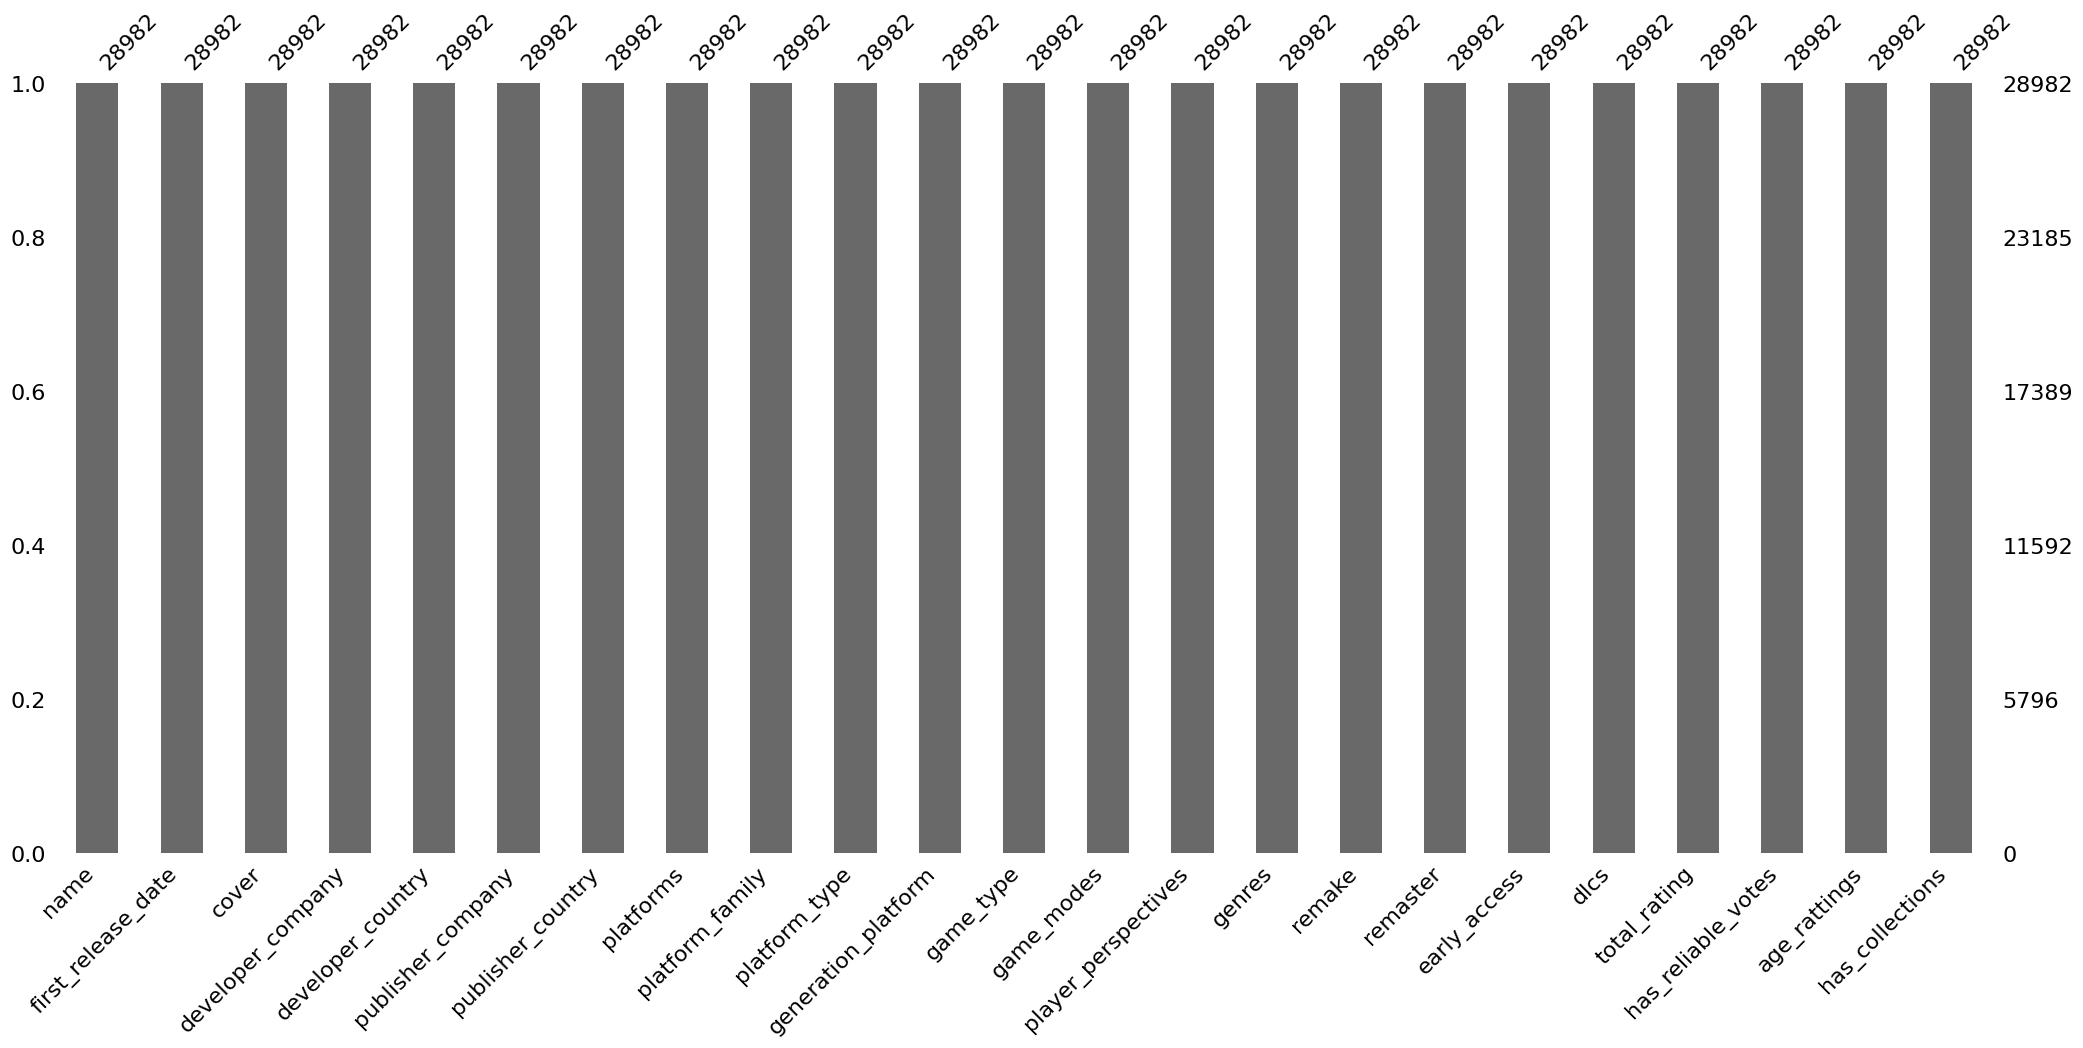

In [63]:
missingno.bar(df)

In [64]:
# Let's put everything back in the correct order
columns_order = [
    'name', 'first_release_date', 'cover','total_rating', 'has_reliable_votes', 'age_rattings', # Identification
    'developer_company', 'developer_country','publisher_company', 'publisher_country', # developer / publisher
    'platforms', 'platform_family', 'platform_type', 'generation_platform', # platform 
    'game_type', 'game_modes', 'player_perspectives', 'genres',   # Game characteristic
    'has_collections', 'remake', 'remaster', 'early_access', 'dlcs', # Details around the game
]

df = df[columns_order]

In [65]:
df.head()

,name,first_release_date,cover,total_rating,has_reliable_votes,age_rattings,developer_company,developer_country,publisher_company,publisher_country,...,generation_platform,game_type,game_modes,player_perspectives,genres,has_collections,remake,remaster,early_access,dlcs
0,Retaliate,2024-07-15,//images.igdb.com/igdb/image/upload/t_thumb/co...,76.0,False,Everyone,[Romans I XVI Gaming],[United States],[Romans I XVI Gaming],[United States],...,8,Main Game,[Single player],[Bird view / Isometric],"[Shooter, Indie, Arcade]",False,False,False,False,0
1,MX vs. ATV: Supercross - Encore,2015-10-27,//images.igdb.com/igdb/image/upload/t_thumb/co...,35.0,True,Everyone,[Rainbow Studios],[United States],[Nordic Games Publishing],[Austria],...,8,Main Game,"[Single player, Multiplayer]","[First person, Third person]","[Racing, Simulator, Sport]",True,False,False,False,7
2,Super Hipster Lumberjack,2015-07-20,//images.igdb.com/igdb/image/upload/t_thumb/co...,80.0,False,Everyone,Unknown,Unknown,Unknown,Unknown,...,0,Main Game,[Single player],[Unknown],"[Platform, Indie]",False,False,False,False,0
3,Trianga's Project: Battle Splash 2.0,2023-09-26,//images.igdb.com/igdb/image/upload/t_thumb/co...,70.0,False,Everyone,Unknown,Unknown,Unknown,Unknown,...,0,Main Game,"[Single player, Multiplayer, Co-operative]","[First person, Third person]","[Shooter, Sport, Indie]",False,False,False,False,1
4,Go-Go Town!,2024-06-18,//images.igdb.com/igdb/image/upload/t_thumb/co...,85.0,False,Everyone,[Prideful Sloth],[Australia],"[Cult Games, Prideful Sloth]",[Australia],...,9,Main Game,"[Single player, Multiplayer, Co-operative, Spl...",[Third person],"[Simulator, Indie]",False,False,False,True,0


## Export

In [66]:
df.to_csv("games.csv", index=False)

In [67]:
df[df["name"] == "The Legend of Zelda: Breath of the Wild"]

,name,first_release_date,cover,total_rating,has_reliable_votes,age_rattings,developer_company,developer_country,publisher_company,publisher_country,...,generation_platform,game_type,game_modes,player_perspectives,genres,has_collections,remake,remaster,early_access,dlcs
7294,The Legend of Zelda: Breath of the Wild,2017-03-03,//images.igdb.com/igdb/image/upload/t_thumb/co...,95.123827,True,Teen,[Nintendo EPD Production Group No. 3],[Japan],[Nintendo],[Japan],...,8,Main Game,[Single player],[Third person],"[Puzzle, Adventure]",True,False,False,False,2
